In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

In [4]:
print('PyTorch version:', torch.__version__)

PyTorch version: 1.4.0


In [5]:
# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
# Download MNIST dataset
mnist_trainset = MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.Resize(32),                                                           
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))
                                ]))

mnist_validset = MNIST('data', train=False, download=True,
                                transform=transforms.Compose([
                                    transforms.Resize(32),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))
                                ]))

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [7]:
# Download CIFAR10 dataset
cifar_trainset = CIFAR10('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))
                                ]))

cifar_validset = CIFAR10('data', train=False, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))
                                ]))

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [8]:
# MNIST Info
img, label = mnist_trainset[0]
print('Img shape: ', img.shape)
print('Label: ', label)

Img shape:  torch.Size([1, 32, 32])
Label:  5


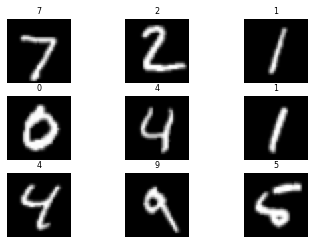

In [9]:
# MNIST Plot (image and label)
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # extract the image and label
  [img, label] = mnist_validset[i]
  # plot image and label
  plt.imshow(img.numpy()[0], cmap=plt.get_cmap('gray'))
  plt.title(label, fontsize=8)
  plt.axis('off')
# show the figure
plt.show()

In [10]:
# CIFAR10 Info
img, label = cifar_trainset[0]
print('Img shape: ', img.shape)
print('Label: ', label)

Img shape:  torch.Size([3, 32, 32])
Label:  6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


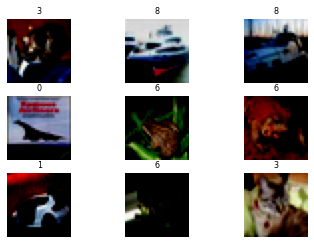

In [62]:
# CIFAR10 Plot (image and label)
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # extract the image and label
  [img, label] = cifar_validset[i]
  # plot image and label
  plt.title(label, fontsize=8)
  i = np.transpose(img, (1, 2, 0))
  plt.imshow(i, vmin=0, vmax=255)
  plt.axis('off')
# show the figure
plt.show()

In [12]:
# We create a new image Z(4,28,28) of each cifar image
CIFAR=[]
for i in range(len(cifar_trainset)):
  m = torch.empty(4,32,32)
  m[0,:,:]=cifar_trainset[i][0][0]          # channel 0 to 2 = pixel value
  m[1,:,:]=cifar_trainset[i][0][1]           
  m[2,:,:]=cifar_trainset[i][0][2]         
  m[3,:,:]=mnist_trainset[i][0]                  # channel 3 = Mnist image
  CIFAR.append((m, mnist_trainset[i][1]))

print(len(CIFAR), CIFAR[0][0].size())

50000 torch.Size([4, 32, 32])


In [13]:
# We create a new image Z(4,28,28) of each cifar image in validset
CIFAR_V=[]
for i in range(len(cifar_validset)):
  v = torch.empty(4,32,32)
  v[0,:,:]=cifar_validset[i][0][0]           # channel 1 = pixel value
  v[1,:,:]=cifar_validset[i][0][1]
  v[2,:,:]=cifar_validset[i][0][2]
  v[3,:,:]=mnist_validset[i][0]                  # channel 2 = Mnist image
  CIFAR_V.append((v, mnist_validset[i][1]))

print(len(CIFAR_V), CIFAR_V[0][0][0].size())

10000 torch.Size([32, 32])


In [0]:
batch_size = 64
batch_size_val = 64

In [0]:
# Setup data loaders
train_loader = torch.utils.data.DataLoader( 
    CIFAR,
    batch_size=batch_size, 
    shuffle=True)

valid_loader = torch.utils.data.DataLoader( 
    CIFAR_V,
    batch_size=batch_size_val, 
    shuffle=False)

In [0]:
# UNet
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # 32 x 32
        self.conv1_e1 = ConvAct(4, 16)
        #self.conv1_e1 = ConvAct(2, 16)       
        self.conv1_e2 = ConvAct(16, 16)
        self.down1 = nn.MaxPool2d(2, 2)

        # 16 x 16
        self.conv2_e1 = ConvAct(16, 32)
        self.conv2_e2 = ConvAct(32, 32)
        self.down2 = nn.MaxPool2d(2, 2)
        
        # 8 x 8
        self.conv3_e1 = ConvAct(32, 64)
        self.conv3_e2 = ConvAct(64, 64)
        self.down3 = nn.MaxPool2d(2, 2)
        
        # 4 x 4
        self.conv4_e1 = ConvAct(64, 128)
        self.conv4_e2 = ConvAct(128, 128)
        self.down4 = nn.MaxPool2d(2, 2)

        # 2 x 2
        self.conv5_1 = ConvAct(128, 256)
        self.conv5_2 = ConvAct(256, 256)
        
        # 4 x 4
        self.up4 = nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)
        self.reSample1 = nn.Upsample(size=(4,4), mode='bilinear')
        self.conv4_d1 = ConvAct(256, 128)
        self.conv4_d2 = ConvAct(128, 128)

        # 8 x 8
        self.up3 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.reSample2 = nn.Upsample(size=(8,8), mode='bilinear')
        self.conv3_d1 = ConvAct(128, 64)
        self.conv3_d2 = ConvAct(64, 64)

        # 16 x 16
        self.up2 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.conv2_d1 = ConvAct(64, 32)
        self.conv2_d2 = ConvAct(32, 32)

        # 32 x 32
        self.up1 = nn.ConvTranspose2d(32, 16, 3, 2, 1, 1)
        self.conv1_d1 = ConvAct(32, 16)
        self.conv1_d2 = ConvAct(16, 16)

        self.output_layer = nn.Conv2d(16, 3, 3, 1, 1)
        #self.output_layer = nn.Conv2d(16, 1, 3, 1, 1)

    def forward(self, x):
        
        # level 1 - encode
        x = self.conv1_e1(x)
        x = out1 = self.conv1_e2(x)
        x = self.down1(x)

        # level 2 - encode
        x = self.conv2_e1(x)
        x = out2 = self.conv2_e2(x)
        x = self.down2(x)

        # level 3 - encode
        x = self.conv3_e1(x)
        x = out3 = self.conv3_e2(x)
        x = self.down3(x)

        # level 4 - encode
        x = self.conv4_e1(x)
        x = out4 = self.conv4_e2(x)
        x = self.down4(x)

        # level 5 - encode/decode
        x = self.conv5_1(x)
        x = self.conv5_2(x)

        # level 4 - decode
        x = self.up4(x)
        #x = self.reSample1(x)
        x = torch.cat((x, out4), dim=1)
        x = self.conv4_d1(x)
        x = self.conv4_d2(x)

        # level 3 - decode
        x = self.up3(x)
        #x = self.reSample2(x)
        x = torch.cat((x, out3), dim=1)
        x = self.conv3_d1(x)
        x = self.conv3_d2(x)

        # level 2 - decode
        x = self.up2(x)
        x = torch.cat((x, out2), dim=1)
        x = self.conv2_d1(x)
        x = self.conv2_d2(x)

        # level 1 - decode
        x = self.up1(x)
        x = torch.cat((x, out1), dim=1)
        x = self.conv1_d1(x)
        x = self.conv1_d2(x)

        x = self.output_layer(x)
        return x
    

_named_activations = {
    'relu': nn.ReLU,
    'sigmoid': nn.Sigmoid,
    'prelu': nn.PReLU,
    'leakyrelu': nn.LeakyReLU,
    'elu': nn.ELU
}


def same_padding(kernel, dilation):
    return int((kernel + (kernel - 1) * (dilation - 1) - 1) / 2)


def get_activation_by_name(name, **kwargs):
    return _named_activations[name](**kwargs)


class ConvAct(nn.Module):
    """Conv->Activation"""
    def __init__(
            self, in_channels, out_channels,
            kernel=3, dilation=1, activation='relu'):
        super(ConvAct, self).__init__()
        padding = same_padding(kernel, dilation)
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel,
            padding=padding,
            dilation=dilation)
        self.activation = get_activation_by_name(activation)
        self.reset_parameters()

    def reset_parameters(self):
        self.conv.reset_parameters()
        nn.init.xavier_uniform_(self.conv.weight)

    def forward(self, x):
        return self.activation(self.conv(x))

In [0]:
# UNet
class UNet2(nn.Module):
    def __init__(self):
        super(UNet2, self).__init__()

        # 32 x 32
        self.conv1_e1 = ConvAct(3, 16)
        #self.conv1_e1 = ConvAct(2, 16)       
        self.conv1_e2 = ConvAct(16, 16)
        self.down1 = nn.MaxPool2d(2, 2)

        # 16 x 16
        self.conv2_e1 = ConvAct(16, 32)
        self.conv2_e2 = ConvAct(32, 32)
        self.down2 = nn.MaxPool2d(2, 2)
        
        # 8 x 8
        self.conv3_e1 = ConvAct(32, 64)
        self.conv3_e2 = ConvAct(64, 64)
        self.down3 = nn.MaxPool2d(2, 2)
        
        # 4 x 4
        self.conv4_e1 = ConvAct(64, 128)
        self.conv4_e2 = ConvAct(128, 128)
        self.down4 = nn.MaxPool2d(2, 2)

        # 2 x 2
        self.conv5_1 = ConvAct(128, 256)
        self.conv5_2 = ConvAct(256, 256)
        
        # 4 x 4
        self.up4 = nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)
        self.reSample1 = nn.Upsample(size=(4,4), mode='bilinear')
        self.conv4_d1 = ConvAct(256, 128)
        self.conv4_d2 = ConvAct(128, 128)

        # 8 x 8
        self.up3 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.reSample2 = nn.Upsample(size=(8,8), mode='bilinear')
        self.conv3_d1 = ConvAct(128, 64)
        self.conv3_d2 = ConvAct(64, 64)

        # 16 x 16
        self.up2 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.conv2_d1 = ConvAct(64, 32)
        self.conv2_d2 = ConvAct(32, 32)

        # 32 x 32
        self.up1 = nn.ConvTranspose2d(32, 16, 3, 2, 1, 1)
        self.conv1_d1 = ConvAct(32, 16)
        self.conv1_d2 = ConvAct(16, 16)

        #self.output_layer = nn.Conv2d(16, 4, 3, 1, 1)
        self.output_layer = nn.Conv2d(16, 1, 3, 1, 1)

    def forward(self, x):
        
        # level 1 - encode
        x = self.conv1_e1(x)
        x = out1 = self.conv1_e2(x)
        x = self.down1(x)

        # level 2 - encode
        x = self.conv2_e1(x)
        x = out2 = self.conv2_e2(x)
        x = self.down2(x)

        # level 3 - encode
        x = self.conv3_e1(x)
        x = out3 = self.conv3_e2(x)
        x = self.down3(x)

        # level 4 - encode
        x = self.conv4_e1(x)
        x = out4 = self.conv4_e2(x)
        x = self.down4(x)

        # level 5 - encode/decode
        x = self.conv5_1(x)
        x = self.conv5_2(x)

        # level 4 - decode
        x = self.up4(x)
        #x = self.reSample1(x)
        x = torch.cat((x, out4), dim=1)
        x = self.conv4_d1(x)
        x = self.conv4_d2(x)

        # level 3 - decode
        x = self.up3(x)
        #x = self.reSample2(x)
        x = torch.cat((x, out3), dim=1)
        x = self.conv3_d1(x)
        x = self.conv3_d2(x)

        # level 2 - decode
        x = self.up2(x)
        x = torch.cat((x, out2), dim=1)
        x = self.conv2_d1(x)
        x = self.conv2_d2(x)

        # level 1 - decode
        x = self.up1(x)
        x = torch.cat((x, out1), dim=1)
        x = self.conv1_d1(x)
        x = self.conv1_d2(x)

        x = self.output_layer(x)
        return x
    

_named_activations = {
    'relu': nn.ReLU,
    'sigmoid': nn.Sigmoid,
    'prelu': nn.PReLU,
    'leakyrelu': nn.LeakyReLU,
    'elu': nn.ELU
}


def same_padding(kernel, dilation):
    return int((kernel + (kernel - 1) * (dilation - 1) - 1) / 2)


def get_activation_by_name(name, **kwargs):
    return _named_activations[name](**kwargs)


class ConvAct(nn.Module):
    """Conv->Activation"""
    def __init__(
            self, in_channels, out_channels,
            kernel=3, dilation=1, activation='relu'):
        super(ConvAct, self).__init__()
        padding = same_padding(kernel, dilation)
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel,
            padding=padding,
            dilation=dilation)
        self.activation = get_activation_by_name(activation)
        self.reset_parameters()

    def reset_parameters(self):
        self.conv.reset_parameters()
        nn.init.xavier_uniform_(self.conv.weight)

    def forward(self, x):
        return self.activation(self.conv(x))

In [0]:
network = UNet()
network.to(device);

In [0]:
network2 = UNet2()
network2.to(device);

In [0]:
#optimizer1 = optim.Adam(network.parameters(), lr=0.01)
optimizer1 = optim.SGD(network.parameters(), lr=0.001, momentum=0.9, nesterov=True)
optimizer2 = optim.SGD(network2.parameters(), lr=0.001, momentum=0.9, nesterov=True)

criterion1 = nn.MSELoss()
#criterion2 = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()

In [0]:
def train_epoch(train_loader, network, network2, optimizer1, optimizer2, criterion1, criterion2):

  network.train()
  network2.train()
  
  avg_losses = []
  clf_losses = []

  avg_weight = 0.9
  clf_weight = 1.0 - avg_weight
  
  y_pred = []
  y_true = []

  # for each batch
  for batch_idx, (data, target) in enumerate(train_loader):
      
      # move training data to the GPU
      data, target = data.to(device), target.to(device)
      image = data[:, 0:3, :, :].detach()

      # save ground truth
      y_true.extend(target.data.cpu().numpy())
      
      # clear previous gradient computation
      optimizer1.zero_grad()
      optimizer2.zero_grad()

      # froward propagation 
      output = network(data)
      output2 = network2(output)

      # save predictions
      y_pred.extend(output2.data.cpu().numpy())
      
      # calculate loss
      loss1 = criterion1(output[:,0:3,:,:], image)
      loss2 = criterion2(output2[:,0,:,:], data[:,-1,:,:])

      total_loss = avg_weight * loss1 + clf_weight * loss2
      total_loss.backward()
      
      # update model weights
      optimizer1.step()
      optimizer2.step()
      
      avg_losses.append(float(loss1.item()))
      clf_losses.append(float(loss2.item()))

      # print progress
      if batch_idx % 100 == 0:
          print(f'[{epoch}] {batch_idx:03d}/{len(train_loader)} '
                f'avg_loss: {loss1.item():.06f} '
                f'clf_loss: {loss2.item():.06f} ')
          
  # calc avg losses
  avg_loss = np.mean(avg_losses)
  clf_loss = np.mean(clf_losses)

  return avg_loss, clf_loss, output, output2, y_true, y_pred

In [0]:
def eval_epoch(val_loader, network, network2, criterion1, criterion2):
    network.eval()
    network2.eval()

    avg_losses = []
    clf_losses = []
    acc_scores = []

    yvalid_true = []
    yvalid_pred = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
          # move training data to the GPU
          data, target = data.to(device), target.to(device)
          image = data[:, 0:3, :, :].detach()

          # save ground truth
          yvalid_true.extend(target.data.cpu().numpy())

          # froward propagation 
          output = network(data)
          output2 = network2(output)

          # save predictions
          yvalid_pred.extend(output2.argmax(dim=1).data.cpu().numpy())
          
          # calculate loss
          loss1 = criterion1(output[:,0:3,:,:], image)
          loss2 = criterion2(output2[:,0,:,:], data[:,-1,:,:])

          avg_losses.append(float(loss1.item()))
          clf_losses.append(float(loss2.item()))
            
    # calculate accuracy
    #acc = accuracy_score(yvalid_true, yvalid_pred)

    # calc avg losses
    avg_loss = np.mean(avg_losses)
    clf_loss = np.mean(clf_losses)

        
    print('Valid Epoch: {} \tLoss: {:.6f}\tLoss2: {:.6f}\t \n'.format(
                epoch, avg_loss, clf_loss))
    #print('Valid accuracy: {:.4f}%\n'.format(float(acc) * 100))

    return avg_loss, clf_loss, image, output, output2, yvalid_true, yvalid_pred

In [0]:
num_epochs = 50

In [130]:
# Init lists to save the evolution of the training & test losses/accuracy.
avg_losses = []
clf_losses = []
avgvalid_losses = []
clfvalid_losses = []


# For each epoch
for epoch in range(1, num_epochs + 1):

  # Compute & save the average training loss for the current epoch
  avg_loss, clf_loss, output, output2, y_true, y_pred = train_epoch(train_loader, network, network2, optimizer1, optimizer2, criterion1, criterion2)
  avg_losses.append(avg_loss)
  clf_losses.append(clf_loss)

  avgval_loss, clfval_loss, v_data, val_output, val_output2, yvalid_true, yvalid_pred = eval_epoch(valid_loader, network, network2, criterion1, criterion2)
  avgvalid_losses.append(avgval_loss)
  clfvalid_losses.append(clfval_loss)


[1] 000/782 avg_loss: 0.010225 clf_loss: 0.019974 
[1] 100/782 avg_loss: 0.006691 clf_loss: 0.016420 
[1] 200/782 avg_loss: 0.006343 clf_loss: 0.017670 
[1] 300/782 avg_loss: 0.005775 clf_loss: 0.017394 
[1] 400/782 avg_loss: 0.006982 clf_loss: 0.018511 
[1] 500/782 avg_loss: 0.007272 clf_loss: 0.018026 
[1] 600/782 avg_loss: 0.006879 clf_loss: 0.016875 
[1] 700/782 avg_loss: 0.006172 clf_loss: 0.017191 
Valid Epoch: 1 	Loss: 0.006952	Loss2: 0.017416	 

[2] 000/782 avg_loss: 0.005335 clf_loss: 0.016694 
[2] 100/782 avg_loss: 0.007209 clf_loss: 0.018864 
[2] 200/782 avg_loss: 0.006110 clf_loss: 0.017281 
[2] 300/782 avg_loss: 0.006818 clf_loss: 0.018411 
[2] 400/782 avg_loss: 0.005466 clf_loss: 0.015488 
[2] 500/782 avg_loss: 0.007447 clf_loss: 0.018380 
[2] 600/782 avg_loss: 0.006108 clf_loss: 0.018064 
[2] 700/782 avg_loss: 0.006990 clf_loss: 0.017894 
Valid Epoch: 2 	Loss: 0.006841	Loss2: 0.017042	 

[3] 000/782 avg_loss: 0.007492 clf_loss: 0.018763 
[3] 100/782 avg_loss: 0.007461 cl

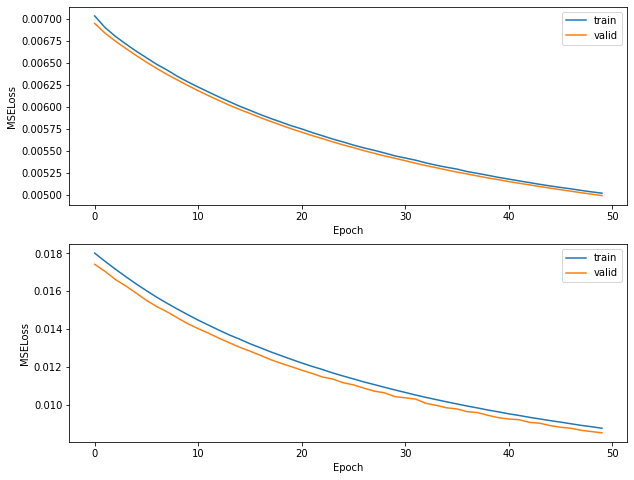

In [131]:
# Loss function plots
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('MSELoss')
plt.plot(avg_losses, label='train')
plt.plot(avgvalid_losses, label='valid')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('MSELoss')
plt.plot(clf_losses, label='train')
plt.plot(clfvalid_losses, label='valid')
plt.legend()

In [132]:
a = np.mean(avg_losses)
b = np.mean(clf_losses)
c = np.mean(avgvalid_losses)
d = np.mean(clfvalid_losses)
print("Train: AvgLoss", a, "\tClfLoss ", b)
print("Valid: AvgLoss", c, "\tClfLoss ", d)

Train: AvgLoss 0.005721739432905488 	ClfLoss  0.012078389607446123
Valid: AvgLoss 0.005685607459467308 	ClfLoss  0.011719532702948636


In [133]:
# Train - Original image = message
o1=output2.data.cpu()
o1.size()

torch.Size([16, 1, 32, 32])

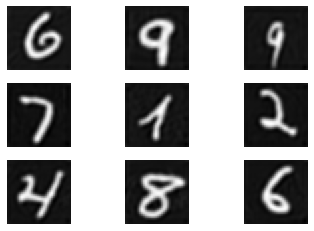

In [134]:
# Plot the first 9 original images and it's label
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # extract the image and label
  img = o1[i]
  # plot MNIST image and label
  plt.imshow(img.numpy()[0], cmap=plt.get_cmap('gray'))
  # plot CIFAR image and label
  #i = np.transpose(img, (1, 2, 0))
  #plt.imshow(i, vmin=0, vmax=255)
  plt.axis('off')
# show the figure
plt.show()

In [135]:
# Train - steganography image
f=output.data.cpu()
f.size()

torch.Size([16, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


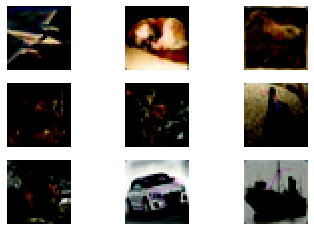

In [136]:
# Plot the first 9 steganography images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # extract the image and label
  img = f[i]
  # plot MNIST image and label
  #plt.imshow(img.numpy()[0], cmap=plt.get_cmap('gray'))
  # plot CIFAR image and label
  i = np.transpose(img, (1, 2, 0))
  plt.imshow(i, interpolation='nearest')
  plt.axis('off')
# show the figure
plt.show()

In [137]:
# Validation - Original image = message
vo=val_output2.data.cpu()
vo.size()

torch.Size([16, 1, 32, 32])

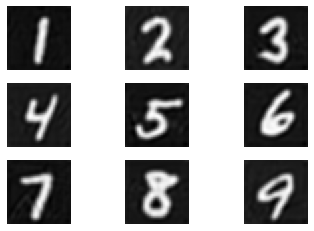

In [138]:
# Plot the first 9 steganography images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # extract the image and label
  img = vo[i]
  # plot MNIST image and label
  plt.imshow(img.numpy()[0], cmap=plt.get_cmap('gray'))
  # plot CIFAR image and label
  #i = np.transpose(img, (1, 2, 0))
  #plt.imshow(i, interpolation='nearest')
  plt.axis('off')
# show the figure
plt.show()

In [139]:
# Validation - steganography image
vo1=val_output.data.cpu()
vo1.size()

torch.Size([16, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


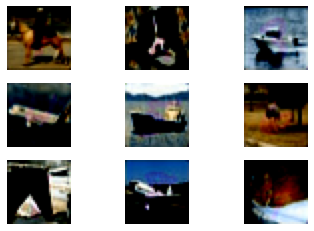

In [140]:
# Plot the first 9 original images and it's label
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # extract the image and label
  img = vo1[i]
  # plot MNIST image and label
  #plt.imshow(img.numpy()[0], cmap=plt.get_cmap('gray'))
  # plot CIFAR image and label
  i = np.transpose(img, (1, 2, 0))
  plt.imshow(i, vmin=0, vmax=255)
  plt.axis('off')
# show the figure
plt.show()

In [141]:
# Validation - steganography image
vo1=v_data.data.cpu()
vo1.size()

torch.Size([16, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


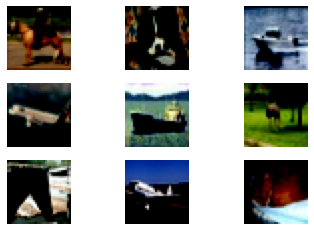

In [142]:
# Plot the first 9 original images and it's label
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # extract the image and label
  img = vo1[i]
  # plot MNIST image and label
  #plt.imshow(img.numpy()[0], cmap=plt.get_cmap('gray'))
  # plot CIFAR image and label
  i = np.transpose(img, (1, 2, 0))
  plt.imshow(i, vmin=0, vmax=255)
  plt.axis('off')
# show the figure
plt.show()